In [ ]:
import seaborn as sns  # graphs
import numpy as np # numerical python, vectors, array
import pandas as pd # csv, excel types
import matplotlib.pyplot as plt # graphs
import os #reading and saving files
from tensorflow.keras.preprocessing.image import ImageDataGenerator #to convert to tensor
import tensorflow as tf
import keras
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import EfficientNetB0

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tqdm import tqdm

In [ ]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset

Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 31.80 MiB/s, done.


In [ ]:
train_img  = [] # X_train
train_labels = []

test_img = []
test_labels = []

path_train = ('brain-tumor-classification-dataset/Training/')
path_test = ('brain-tumor-classification-dataset/Testing/')
img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)


# train 80% 90, 10%
# test 20%

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

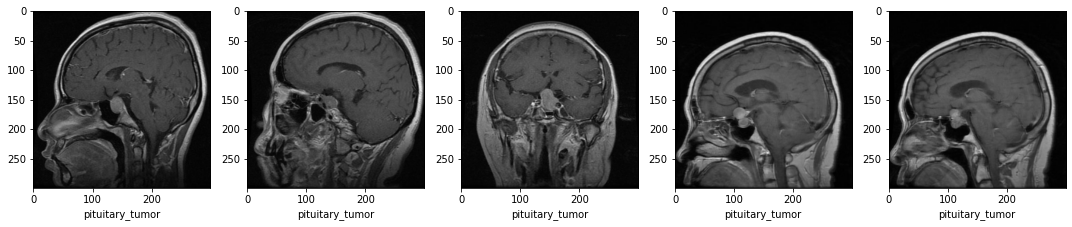

In [ ]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

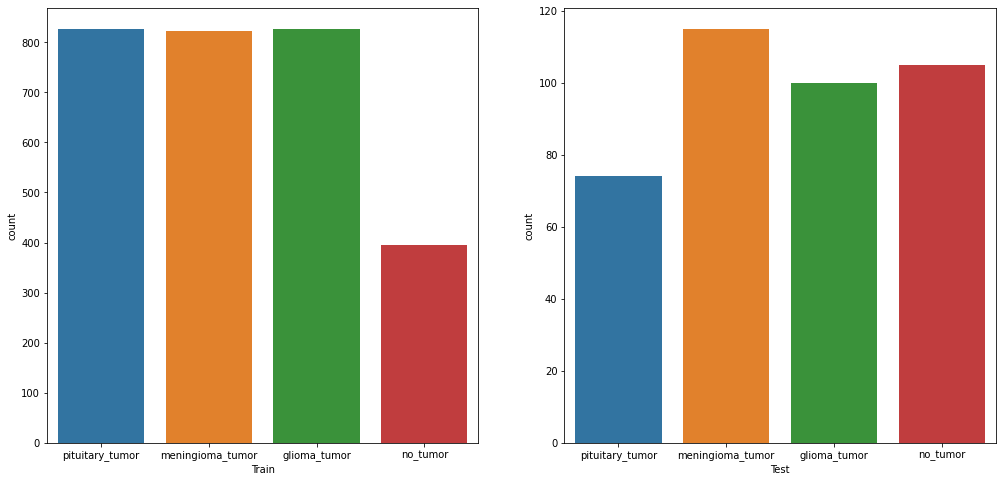

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

# BASE MODEL

In [ ]:
base_model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4, activation='sigmoid')
  ])
base_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = base_model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_labels)), validation_split=0.1, epochs =20, verbose=1, batch_size=32)

Epoch 1/20
81/81 [==============================] - 20s 106ms/step - loss: 2.9466 - accuracy: 0.5521 - val_loss: 2.8105 - val_accuracy: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 7s 90ms/step - loss: 0.7217 - accuracy: 0.6794 - val_loss: 2.3239 - val_accuracy: 0.0348
Epoch 3/20
81/81 [==============================] - 7s 90ms/step - loss: 0.6263 - accuracy: 0.7336 - val_loss: 2.3995 - val_accuracy: 0.1777
Epoch 4/20
81/81 [==============================] - 7s 90ms/step - loss: 0.4829 - accuracy: 0.8006 - val_loss: 2.7469 - val_accuracy: 0.1603
Epoch 5/20
81/81 [==============================] - 7s 91ms/step - loss: 0.3793 - accuracy: 0.8571 - val_loss: 2.3579 - val_accuracy: 0.3031
Epoch 6/20
81/81 [==============================] - 8s 99ms/step - loss: 0.3239 - accuracy: 0.8761 - val_loss: 2.4695 - val_accuracy: 0.3345
Epoch 7/20
81/81 [==============================] - 7s 92ms/step - loss: 0.2322 - accuracy: 0.9133 - val_loss: 1.8287 - val_accuracy: 0.5226
Epoch 8

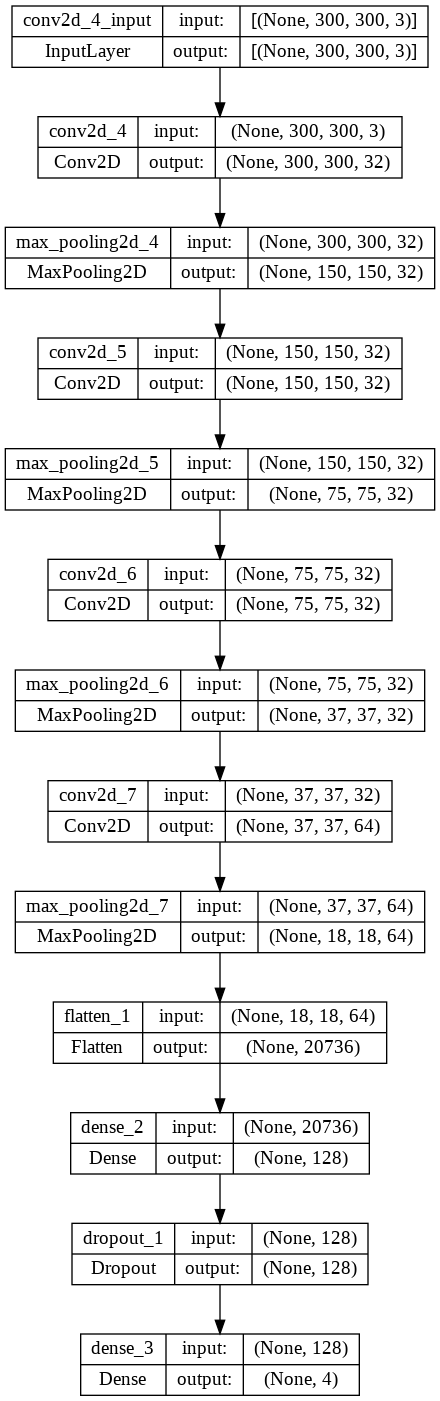

In [ ]:
tf.keras.utils.plot_model(base_model, to_file="my_model.png", show_shapes=True)

In [ ]:
pred = base_model.predict(tf.cast(test_img, tf.float32))
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(np.array(pd.get_dummies(test_labels)),axis=1)

13/13 [==============================] - 1s 58ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.72      0.21      0.33       100
           1       0.55      0.99      0.70       115
           2       0.70      0.70      0.70       105
           3       0.94      0.65      0.77        74

    accuracy                           0.65       394
   macro avg       0.73      0.64      0.63       394
weighted avg       0.71      0.65      0.62       394



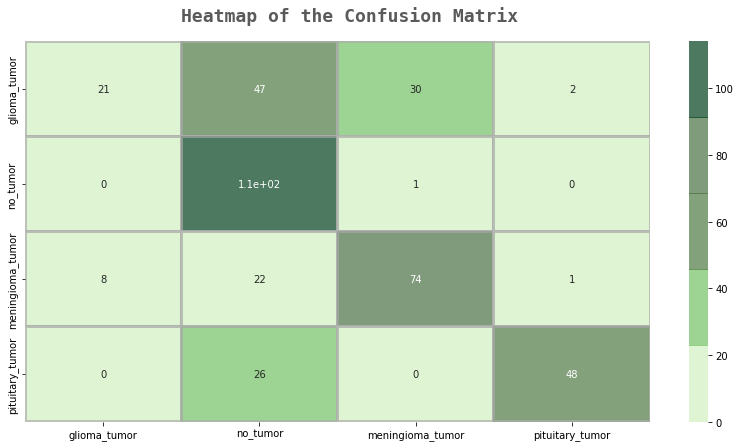

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# TRANSFER LEARNING

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 147.46it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train)

In [ ]:
print(X_train.shape)

(3264, 150, 150, 3)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1)

In [ ]:
# Performing One Hot Encoding on the labels after converting it into numerical values:

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15 batch_size=32)

Epoch 1/15
83/83 [==============================] - 13s 162ms/step - loss: 0.0377 - accuracy: 0.9902 - val_loss: 0.1274 - val_accuracy: 0.9728
Epoch 2/15
83/83 [==============================] - 14s 164ms/step - loss: 0.0386 - accuracy: 0.9894 - val_loss: 0.1201 - val_accuracy: 0.9592
Epoch 3/15
83/83 [==============================] - 14s 164ms/step - loss: 0.0282 - accuracy: 0.9939 - val_loss: 0.0638 - val_accuracy: 0.9762
Epoch 4/15
83/83 [==============================] - 14s 169ms/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.1176 - val_accuracy: 0.9694
Epoch 5/15
83/83 [==============================] - 13s 160ms/step - loss: 0.0172 - accuracy: 0.9921 - val_loss: 0.2007 - val_accuracy: 0.9558
Epoch 6/15
83/83 [==============================] - 13s 160ms/step - loss: 0.0560 - accuracy: 0.9818 - val_loss: 0.2956 - val_accuracy: 0.9252
Epoch 7/15
83/83 [==============================] - 13s 161ms/step - loss: 0.0324 - accuracy: 0.9909 - val_loss: 0.2931 - val_accuracy: 0.9286

In [ ]:
pred2 = model.predict(X_test)
pred2 = np.argmax(pred2,axis=1)
y_test_new2 = np.argmax(y_test,axis=1)

11/11 [==============================] - 2s 72ms/step


In [ ]:
print(classification_report(y_test_new2,pred2))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       100
           1       0.95      0.75      0.84        52
           2       0.68      1.00      0.81        89
           3       1.00      0.91      0.95        86

    accuracy                           0.87       327
   macro avg       0.91      0.86      0.87       327
weighted avg       0.90      0.87      0.87       327



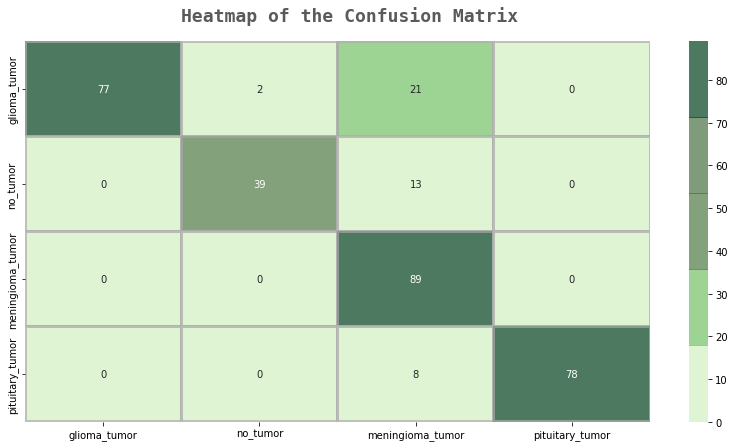

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()